# 1 Neural Networks 
In ex3, we implemented feedforward propagation for neural networks and 
used it to predict handwritten digits with the weights we provided. 
In ex4, we will implement the backpropagation algorithm to learn the parameters for the neural network.

In [1]:
import scipy.io # to load .mat file
import numpy.random # to randomly select 
import numpy as np 
import matplotlib.pyplot as plt
from scipy import optimize

## 1.1 Visualizing the data 

In [2]:
data = scipy.io.loadmat('data/ex4data1.mat')
X, y = data['X'], data['y']
print("X's shape is", X.shape)
print("y's shape is", y.shape)

# # change 10 into 0 in y 
# for i,e in enumerate(y):
#     if e==10:
#         y[i] = 0
print('Labels in y are', np.unique(y))

X's shape is (5000, 400)
y's shape is (5000, 1)
Labels in y are [ 1  2  3  4  5  6  7  8  9 10]


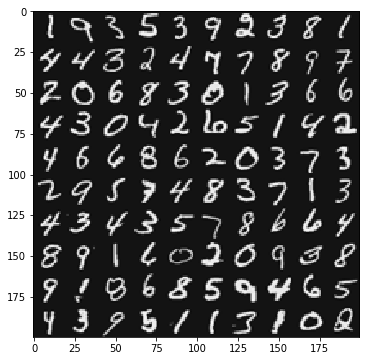

In [3]:
def displayData(data):
    """
    displays 2D data in a nice grid
    """
    h, w = int(data.shape[0]**(1/2)), int(data.shape[1]**(1/2))
    plt.figure(figsize=(6,6))
    img = np.zeros((1,w*h)) # prevent np.append's ValueError: arrays must have same number of dimensions
    for i in range(h):
        tmp = data[i*h:(i+1)*h,:].reshape(w*h,w).T
        img = np.append(img, tmp, axis=0)

    img = img[1:,:] # choose what we need
    plt.imshow(img, cmap=plt.cm.gray)
    plt.show()
    return None
 
m = X.shape[0]
rand_indices = numpy.random.permutation(m) # Randomly select 100 data points to display
sel = X[rand_indices[:100], :]
displayData(sel)    

## 1.2 Model representation 

In [4]:
data = scipy.io.loadmat('data/ex4weights.mat')
Theta1, Theta2 = data['Theta1'], data['Theta2']
print('Theta1 has the shape of', Theta1.shape)
print('Theta2 has the shape of', Theta2.shape)

Theta1 has the shape of (25, 401)
Theta2 has the shape of (10, 26)


In [5]:
# Unroll parameters for the optimizer below (its argument must be 1-D array )
def unroll(Theta1,Theta2):
    t1 = Theta1.reshape((Theta1.shape[0]*Theta1.shape[1],1))
    t2 = Theta2.reshape((Theta2.shape[0]*Theta2.shape[1],1))
    nn_params = np.append(t1, t2, axis=0).flatten()
    return nn_params

nn_params = unroll(Theta1,Theta2)
nn_params.shape

(10285,)

## 1.3 Feedforward and cost function 

In [6]:
input_layer_size  = 400  # 20x20 Input Images of Digits
hidden_layer_size = 25   # 25 hidden units
num_labels = 10          # 10 labels, from 1 to 10 (note that we have mapped "0" to label 10)
m = X.shape[0]           # 5000

def sigmoid(z):
    return 1/(1+np.exp(-z))

def reshapeParams(nn_params):
    """
    The parameters for the neural network are "unrolled" into the vector nn_params (for optimize below)
    and need to be converted back into the weight matrices.
    """
    Theta1 = nn_params[:hidden_layer_size*(input_layer_size + 1)].reshape((hidden_layer_size, (input_layer_size + 1)))
    Theta2 = nn_params[hidden_layer_size*(input_layer_size + 1):].reshape((num_labels, (hidden_layer_size + 1)))
    return Theta1, Theta2

def forwardPropagation(nn_params, X):
    """
    to get a3, i.e., hypothesis 
    """
    Theta1, Theta2 = reshapeParams(nn_params)
    a1 = np.insert(X, 0, 1, axis=1)  # shape:(5000,401)
    z2 = a1.dot(Theta1.T)            # shape:(5000,401) x (401,25) = (5000,25)
    a2 = sigmoid(z2)                 # shape:(5000,25)
    a2 = np.insert(a2, 0, 1, axis=1) # shape:(5000,26)
    a3 = sigmoid(a2.dot(Theta2.T))   # shape:(5000,26) x (26,10) = (5000,10)
    return a3, Theta1, Theta2, z2, a1, a2

def yMatrix(y):
    """
    Expand vector y to a matrix
    """
    # index 0 represent number 1, index 1 represent number 2, ..., index 9 represent number 10
    y_matrix = np.zeros((m,num_labels)) # shape:(5000,10)
    for i in range(m):
        y_matrix[i,y[i]-1] = 1 # the value of y ranges from 1 to 10  

    return y_matrix

def nnCostFunction(nn_params, X, y, _lambda):
    """
    Computes the cost of the neural network. 
    """
    a3, Theta1, Theta2, z2, a1, a2 = forwardPropagation(nn_params, X)
    y_matrix = yMatrix(y)

    # regularization term
    regSum = 0
    for j in range(hidden_layer_size):
        regSum += sum(Theta1[j,1:]**2)
    for j in range(num_labels):
        regSum += sum(Theta2[j,1:]**2)
    
    # compute cost
    J = 0
    for i in range(m):
        J += -(1/m)*sum((np.log(a3[i,:])*y_matrix[i,:]+np.log(1-a3[i,:])*(1-y_matrix[i,:])))
    J += _lambda*regSum/(2*m)
    
    return J

In [7]:
_lambda = 1
J = nnCostFunction(nn_params, X, y, _lambda)
print('Cost at parameters (loaded from ex4weights): {:.6}\n(this value should be about 0.383770)'.format(J))

Cost at parameters (loaded from ex4weights): 0.38377
(this value should be about 0.383770)


# 2 Backpropagation 

## 2.1 Sigmoid gradient 

In [8]:
def sigmoidGradient(z):
    g = sigmoid(z)*(1-sigmoid(z))
    return g

## 2.2 Random initialization 

In [9]:
def randInitializeWeights(L_in, L_out):
    """
    When training neural networks, it is important to randomly initialize the parameters for symmetry breaking. 
    One effective strategy for random initialization is 
    to randomly select values for Θ(l) uniformly in the range [−ε_init, ε_init].
    """
    epsilon_init = 0.12
    W = np.random.rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init
    return W

In [10]:
def Initialize():
    initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
    initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)
    initial_nn_params = unroll(initial_Theta1, initial_Theta2)
    return initial_nn_params
initial_nn_params = Initialize()
initial_nn_params.shape

(10285,)

## 2.3 Backpropagation 

In [11]:
def backPropagation(nn_params, X, y, _lambda):
    """
    Compute the gradients Theta1_grad and Theta2_grad
    """
    a3, Theta1, Theta2, z2, a1, a2 = forwardPropagation(nn_params, X)
    y_matrix = yMatrix(y)
    
    d3 = a3 - y_matrix                              # shape:(5000,10)
    d2 = (d3.dot(Theta2[:,1:]))*sigmoidGradient(z2) # shape:(5000,10) x (10,25) = (5000,25)
    Delta1 = d2.T.dot(a1)                           # shape:(25,5000) x (5000,401) = (25,401) 
    Delta2 = d3.T.dot(a2)                           # shape:(10,5000) x (5000,25) = (10,25)
    Theta1_grad = Delta1/m                          # shape:(25,401) 
    Theta2_grad = Delta2/m                          # shape:(10,25)
    Theta1_grad[:,1:] +=  _lambda*Theta1[:,1:]/m
    Theta2_grad[:,1:] +=  _lambda*Theta2[:,1:]/m

    # Unroll gradients
    grad = unroll(Theta1_grad, Theta2_grad)
    
    return grad

## 2.6 Learning parameters using fmin_cg 

In [12]:
def optimizer(initial_nn_params, X, y, _lambda):  
    res = optimize.fmin_cg(nnCostFunction, x0=initial_nn_params, fprime=backPropagation, args=(X, y, _lambda),
                           maxiter=50, full_output=True, disp=False)
    return res[0], res[1] # res[0]:Parameter that minimizes function = theta
                          # res[1]:Value of function at minimum      = cost  

In [13]:
def predict(Theta1, Theta2, X):
    """
    There are 3 layers in total. One input layer, one hidden layer and one output layer.
    We will implement feedforward propagation for this 3-layer neural network,
    and tranform a3 of shape (5000,10) into p of shape (5000,1) at the end.
    """
    # feedforward propagation
    a1 = np.insert(X, 0, 1, axis=1)  # shape:(5000,401)
    a2 = sigmoid(a1.dot(Theta1.T))   # shape:(5000,401) x (401,25) = (5000,25)
    a2 = np.insert(a2, 0, 1, axis=1) # shape:(5000,26)
    a3 = sigmoid(a2.dot(Theta2.T))   # shape:(5000,26) x (26,10) = (5000,10)
    p = np.c_[np.argmax(a3, axis=1)] # shape:(5000,1)
    
    # the order of labels is 1,2,....,10 and index ranges from 0 to 9 in Python
    for i,_ in enumerate(p):         
        p[i] += 1 
    return p # shape:(5000,1)

In [14]:
# train nn (training time is about 10 seconds)
initial_nn_params = Initialize()
_lambda = 1
nn_params, cost = optimizer(initial_nn_params, X, y, _lambda)
Theta1, Theta2 = reshapeParams(nn_params)

In [15]:
p = predict(Theta1, Theta2, X)
acc = np.mean(p==y)*100 
print('training set accuracy is {:0.3}%'.format(acc))
print('If the implementation is correct, we should see a reported training accuracy of about 95.3%\
       \n(this may vary by about 1% due to the random initialization)')

training set accuracy is 95.4%
If the implementation is correct, we should see a reported training accuracy of about 95.3%       
(this may vary by about 1% due to the random initialization)


prediction is 6
true value is 6


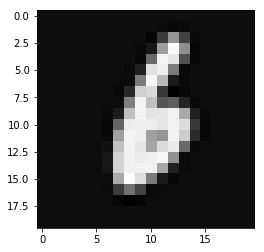

In [16]:
# control+enter many times to check it out
m = X.shape[0]
rand_indices = numpy.random.permutation(m) # Randomly select data point to display
sel = X[rand_indices[:1], :]
img = sel.reshape((20,20)).T
plt.imshow(img, cmap=plt.cm.gray)
pred = int(p[rand_indices[:1]])
true = int(y[rand_indices[:1]])

# label 10 represent number 0
if pred == 10:
    pred = 0
if true == 10:
    true = 0
print('prediction is {}\ntrue value is {}'.format(pred,true))

# 3 Visualizing the hidden layer 
One way to understand what neural network is learning is to visualize
what the representations captured by the hidden units.
That is, display the matrix that maps inputs from input layer to hidden layer,
which is Theta1. 

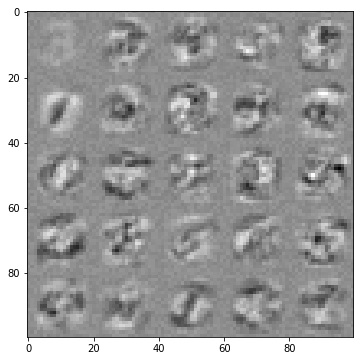

In [17]:
displayData(Theta1[:,1:]) # remove the bias unit